<div align="center">
  <h1></h1>
  <h1>Universidad Nacional de Colombia</h1>
  <h2>Procesamiento del lenguaje natural</h2>
  <h2>Proyecto</h2>
  <h2>Dr Diomedes:
  <h3>Un Bot con sentimiento</h3>
  <h3>Grupo 1</h3>
  <strong>Estudiantes:</strong>  <br>
  Jhojan Sebastian Arango Castillo (<a href="mailto:jsarangoca@unal.edu.co">jsarangoca@unal.edu.co</a>) <br>
  Diego Andres Benitez Duarte (<a href="mailto:dabenitezd@unal.edu.co">dabenitezd@unal.edu.co</a>) <br>
  Jeraldine Muñoz Alvarado (<a href="mailto:jemunozal@unal.edu.co">jemunozal@unal.edu.co</a>) <br>
  Johan Sebastian Suarez Sepulveda (<a href="mailto:jemunozal@unal.edu.co">jssuarezse@unal.edu.co</a>) <br>
  <strong>Profesora:</strong> Elizabeth León Guzmán
</div>

En este Notebook se hará el proceso de Web Scrapping de las canciones de Diomedes Díaz, donde se busca obtener la mayor cantidad de sus letras. La extracción de las letras se hará sobre el cuerpo del documento, sobre un HTML, donde se identificará el contenido que corresponde a la letra de la canción y se hará el scrapping de la misma. Aprovechando la disposición del HTML, se hará también la segmentación de la letra por verso o por estrofa. También se realiza un preprocesamiento de los datos, donde se hace un ajuste de palabras, de signos y de números a texto, dejando todo el contenido en letras minúsculas.

In [ ]:
# Instalación de paquetes
!pip install requests beautifulsoup4 num2words pandas -q

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import random
import re
from typing import List, Dict, Optional, Set
from urllib.parse import urljoin
import unicodedata
from num2words import num2words
import pandas as pd

## Función auxiliar para el manejo de bis y demás repeticiones

Las letras de las canciones a menudo incluyen indicaciones de repetición como "(bis)" o "(2)" al final de un verso para señalar que debe cantarse dos veces. La función `expandir_bis` está diseñada específicamente para manejar esto. Su objetivo es duplicar automáticamente cualquier línea que termine con estas marcas, asegurando que la letra final refleje la estructura real de la canción.

In [ ]:
# Función auxiliar para el manejo de bis y demás repeticiones

def expandir_bis(texto_crudo: str) -> str:
    """
    Toma el texto crudo y duplica las líneas que terminan en (bis), (Bis) o (2).
    """
    # Manejar el (bis) / (Bis) ANTES de eliminar puntuación.
    try:
        texto = re.sub(r'(.+?)\s*\(\s*(bis|Bis|2)\s*\)\s*$', r'\1\n\1', texto_crudo, flags=re.MULTILINE)
    except Exception as e:
        print(f"Advertencia: Falló el procesamiento de repetición: {e}")
        texto = texto_crudo # Continuar con el texto original si falla
    return texto

## Función para normalizar texto

Para que el análisis del texto sea consistente, necesitamos limpiarlo y estandarizarlo. La función `normalizar_letra` se encarga de este preprocesamiento. Realiza varias tareas clave:

- Convierte todo el texto a minúsculas.
- Elimina marcas de estructura como "coro:", "I)", o "[Verso 1]".
- Transforma los dígitos numéricos en palabras (ej. "2" se convierte en "dos").
- Elimina caracteres extraños pero conserva signos de puntuación importantes, tildes y la letra "ñ".
- Finalmente, corrige los espacios en blanco para evitar dobles espacios o saltos de línea innecesarios.

In [ ]:
# Función para normalizar texto, es decir, dejarlo en minúsculas y esas cosas

def normalizar_letra(texto_crudo: str) -> str:
    """
    Limpia y normaliza el texto de una canción, manejando (bis),
    números a letras, convirtiendo a minúsculas y CONSERVANDO PUNTUACIÓN, TILDES Y Ñ.
    """
    if not isinstance(texto_crudo, str): return ""

    # Expandir (bis) por si no se hizo antes.
    texto = expandir_bis(texto_crudo)

    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar nombres de artistas específicos que aparecen en las letras.
    # El :? hace que los dos puntos sean opcionales. \b asegura que sean palabras completas.
    patron_artistas = r'(poncho zuleta|diomedes díaz|beto zabaleta):?\s*'
    texto = re.sub(patron_artistas, '', texto, flags=re.IGNORECASE)

    # Eliminar marcadores de sección (coro, números romanos, etc.)
    # Se usan \b para asegurar que se borren palabras completas y no partes de otras.
    # Se eliminan en orden de más específico a más general.
    texto = re.sub(r'\(coro\)|coro:', '', texto)      # Elimina (coro) y coro:
    texto = re.sub(r'\b(i|ii|iii|iv)\)', '', texto)   # Elimina i), ii), iii), iv)
    texto = re.sub(r'\b(coro|i|ii|iii)\b', '', texto) # Elimina coro, i, ii, iii, iv como palabras solas

    # Eliminar texto entre corchetes (ej. [Coro], [Verso 1])
    texto = re.sub(r'\[.*?\]', '', texto)

    # Convertir números a palabras
    try:
        texto = re.sub(r'\b\d+\b', lambda match: num2words(match.group(0), lang='es'), texto)
    except Exception as e:
        print(f"Advertencia: Falló la conversión de número a palabra: {e}")

    # La regex ahora permite los caracteres del español y signos de puntuación comunes.
    # Se eliminarán caracteres extraños (ej. emojis, símbolos matemáticos, etc.)
    texto = re.sub(r"[^a-zñáéíóúü\s.,¿?¡!;:']", '', texto) # No soy tan pro con las regex

    # Normalizar espacios en blanco (convertir múltiples espacios/saltos a uno solo)
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

## CÓDIGO DEL SERVICIO DE SCRAPING

Aquí definimos las bases de nuestra comunicación con la página web. La función `_get_soup` es el motor que **se conecta a una URL y descarga su contenido HTML**. Para evitar ser bloqueados y para simular una visita humana, configuramos unos `HEADERS` y añadimos una pausa aleatoria entre cada petición, mostrando así un comportamiento respetuoso con el servidor del sitio web.

In [ ]:
# CÓDIGO DEL SERVICIO DE SCRAPING (Solo musica.com, porque las otras no daban)

HEADERS = {
    'User-Agent': 'Mozilla.5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'es-ES,es;q=0.9,en;q=0.8'
}

def _get_soup(url: str) -> Optional[BeautifulSoup]:
    """Obtiene el HTML de una página ESTÁTICA usando Requests."""
    try:
        r = requests.get(url, headers=HEADERS, timeout=10)
        r.raise_for_status()
        pausa = random.uniform(1.0, 2.0) # Ser respetuosos, o me vuelven a poner ban
        print(f"   (Pausa de {pausa:.2f}s para no saturar {url.split('/')[2]})")
        time.sleep(pausa)

        # Forzar decodificación UTF-8
        return BeautifulSoup(r.content, 'html.parser', from_encoding='utf-8')
    except Exception as e:
        print(f"Error al acceder a la URL {url}: {e}")
        return None

### Scrapping

Esta sección contiene las funciones especializadas para extraer la información que nos interesa. Se divide en dos partes principales:

- `_scrape_musica_artist_page`: Esta función visita la página principal del artista y recopila los enlaces a todas sus canciones, creando una lista de URLs que luego visitaremos una por una.
- `_get_lyrics_musica`: Una vez en la página de una canción, esta función se encarga de la tarea más importante: **localizar y extraer el texto de la letra**. Primero, realiza una limpieza previa del HTML para eliminar elementos irrelevantes (como el enlace al "Significado de la letra") y luego extrae las estrofas, respetando los saltos de línea originales.

In [ ]:
# Scrapping

def _scrape_musica_artist_page(artist_url: str, soup: BeautifulSoup) -> List[Dict]:
    """Extrae la lista de canciones de la página del artista."""
    SELECTOR_MUSICA = "ul.listado-letras li a"
    song_links = soup.select(SELECTOR_MUSICA)
    if not song_links:
        print(f"[musica.com] El selector '{SELECTOR_MUSICA}' falló y no encontró canciones.")
        return []

    songs_data = []
    urls_vistas: Set[str] = set()
    for link in song_links:
        title = link.text.strip(); href = link.get('href')
        if href:
            full_url = urljoin(artist_url, href)
            if full_url not in urls_vistas:
                songs_data.append({"title": title, "url": full_url}); urls_vistas.add(full_url)
    return songs_data

def _get_lyrics_musica(soup: BeautifulSoup) -> Optional[List[str]]:
    """Extrae la letra de la página de una canción, limpiando el HTML primero."""

    # Limpieza a nivel de HTML
    try:
        # Buscar el enlace "Significado de la letra".
        # Usando re.compile para una búsqueda exacta que ignore espacios en blanco.
        unwanted_link = soup.find('a', string=re.compile(r'^\s*Significado de la letra\s*$'))

        if unwanted_link:
            # Encontrar el párrafo (<p>) que lo contiene.
            unwanted_p = unwanted_link.find_parent('p')
            if unwanted_p:
                # Eliminar el párrafo completo del HTML.
                print("   (Limpiando párrafo de 'Significado de la letra')...")
                unwanted_p.decompose()
    except Exception as e:
        print(f"   (Advertencia: Ocurrió un error opcional durante la limpieza de 'Significado': {e})")

    SELECTOR = "div#letra"
    lyrics_div = soup.find('div', id='letra')
    if lyrics_div:
        # Encontrar todos los párrafos <p> dentro del div de la letra.
        estrofas_html = lyrics_div.find_all('p')

        estrofas_crudas = []
        for p_tag in estrofas_html:
            # Usar get_text con <br> como separador y limpiar.
            # Esto convierte los <br> en saltos de línea \n dentro de la estrofa.
            texto_estrofa = p_tag.get_text(separator='\n').strip()
            # Añadir solo las estrofas que tienen contenido.
            if texto_estrofa:
                estrofas_crudas.append(texto_estrofa)

        # Devolver la lista de estrofas si se encontró algo
        if estrofas_crudas:
            return estrofas_crudas

    print(f"[musica.com] No se encontró contenido de letra en 'div#letra'.")
    return None

## EJECUCIÓN PRINCIPAL, CREACIÓN DE DATAFRAME Y EXPORTACIÓN
Este es el cerebro del script donde todo se junta y se pone en marcha. El proceso sigue una secuencia lógica:

- Se define el artista y la URL de la que se extraerán los datos.
- Se llama a las funciones de scraping para obtener la lista de canciones y luego iterar sobre cada una, extrayendo su letra.
- Toda la información recopilada (artista, título, letra completa, y cada línea por separado) se organiza y se almacena en un DataFrame de Pandas.
- Finalmente, este DataFrame se exporta a un archivo CSV, creando un conjunto de datos limpio y estructurado, listo para ser analizado.

In [ ]:
# EJECUCIÓN PRINCIPAL, CREACIÓN DE DATAFRAME Y EXPORTACIÓN

# --- Configuración ---
ARTISTA_NOMBRE = "Diomedes Díaz"
# ARTISTA_URL = "https://www.musica.com/letras.asp?letras=16100"
ARTISTA_URL = "https://www.musica.com/letras.asp?letras=16100&orden=alf"
# Cambia esto a 'parrafos' si queremos separar por estrofas en lugar de líneas.
MODO_SEPARACION = 'lineas' # Opciones: 'lineas', 'parrafos'
# ---------------------

print(f"\n--- INICIANDO SCRAPER PARA: {ARTISTA_NOMBRE} ---")

# Obtener la página principal del artista
soup_artista = _get_soup(ARTISTA_URL)
datos_para_df = []

if soup_artista:
    # Obtener la lista de todas las canciones (títulos y URLs)
    canciones_lista = _scrape_musica_artist_page(ARTISTA_URL, soup_artista)
    print(f"[Paso 1] Se encontraron {len(canciones_lista)} canciones para {ARTISTA_NOMBRE}.")
    print("[Paso 2] Iniciando extracción de letras (esto puede tardar, hora de ir por un tinto)...")

    # Iterar sobre CADA canción, visitar su URL y extraer la letra
    for i, cancion in enumerate(canciones_lista):
        titulo_cancion = cancion['title']
        url_cancion = cancion['url']

        print(f"  Procesando {i+1}/{len(canciones_lista)}: {titulo_cancion}")

        # Obtener el 'soup' de la página de la canción
        soup_cancion = _get_soup(url_cancion)

        if soup_cancion:
            # Extraer la letra cruda
            lista_estrofas_crudas = _get_lyrics_musica(soup_cancion)

            if lista_estrofas_crudas:
                # Comparar la primera estrofa (limpia) con el título (limpio)
                primera_estrofa_limpia = lista_estrofas_crudas[0].strip().lower()
                titulo_limpio = titulo_cancion.strip().lower()

                # Si la primera estrofa ES el título de la canción, se elimina de la lista
                if primera_estrofa_limpia == titulo_limpio:
                    print("   (Eliminando primera estrofa por ser el título)...")
                    lista_estrofas_crudas = lista_estrofas_crudas[1:] # Omitir el primer elemento

                # Unir las estrofas crudas para crear el texto completo
                letra_cruda_completa = '\n\n'.join(lista_estrofas_crudas)

                # Expandir (bis) sobre el texto completo.
                letra_expandida = expandir_bis(letra_cruda_completa)

                # Separar en unidades finales (líneas o párrafos) según el modo
                unidades_finales = []
                columna_prefijo = "linea" # Valor por defecto
                if MODO_SEPARACION == 'lineas':
                    unidades_finales = [linea.strip() for linea in letra_expandida.split('\n') if linea.strip()]
                    columna_prefijo = "linea"
                elif MODO_SEPARACION == 'parrafos':
                    unidades_finales = [estrofa.strip() for estrofa in letra_expandida.split('\n\n') if estrofa.strip()]
                    columna_prefijo = "estrofa"

                # Contar las unidades (estrofas || lineas)
                num_unidades = len(unidades_finales)

                # Normalizar la letra (MANTENIENDO PUNTUACIÓN, TILDES Y Ñ) para la columna 3
                letra_normalizada_completa = normalizar_letra(letra_expandida)

                # Crear el diccionario base para la fila
                fila_datos = {
                    "artista": ARTISTA_NOMBRE,
                    "nombre_cancion": titulo_cancion,
                    "letra_completa": letra_normalizada_completa,
                    f"numero_{columna_prefijo}s": num_unidades
                }

                # Añadir cada unidad como una nueva columna
                for idx, unidad in enumerate(unidades_finales):
                    # Normalizamos también cada unidad individualmente
                    unidad_normalizada = normalizar_letra(unidad)
                    fila_datos[f'{columna_prefijo}_{idx+1}'] = unidad_normalizada

                datos_para_df.append(fila_datos)

            else:
                print(f"    > Fallo: No se pudo extraer la letra de {titulo_cancion}")
        else:
            print(f"    > Fallo: No se pudo acceder a la URL {url_cancion}")

    print("\n[Paso 3] Extracción de letras finalizada.")

    # Crear el DataFrame de Pandas
    if datos_para_df:
        print(f"[Paso 4] Creando DataFrame con {len(datos_para_df)} letras extraídas.")
        df = pd.DataFrame(datos_para_df)

        # Mostrar los resultados
        print("\n--- ¡DataFrame Creado con Éxito! ---")
        print(df.iloc[:, :5].head()) # Mostrar las primeras 5 filas

        print(f"\nDimensiones del DataFrame: {df.shape}")

        # VERIFICACIÓN DE UNA CANCIÓN COMPLETA
        print("\n--- Verificación de Letra Completa (Primera Canción) ---")
        try:
            # Mostrar la letra
            print(df.iloc[0]['letra_completa'])
        except (IndexError, KeyError):
            print("El DataFrame está vacío o la columna 'letra_completa' no existe.")

        # EXPORTAR A CSV
        print("\n[Paso 5] Exportando DataFrame a CSV...")
        nombre_archivo = f"letras_musica_com_estructuradas_por_{MODO_SEPARACION}.csv"
        # encoding='utf-8-sig' es importante para que Excel lea bien las tildes y eñes
        df.to_csv(nombre_archivo, index=False, encoding='utf-8-sig')
        print(f"¡Éxito! Archivo '{nombre_archivo}' guardado.")
        print(f"Puedes encontrarlo en el panel de archivos de Colab 📁.")

    else:
        print("No se pudo extraer ninguna letra para crear el DataFrame.")

else:
    print(f"ERROR FATAL: No se pudo obtener la página principal del artista en {ARTISTA_URL}")

print("\n--- PROCESO FINALIZADO. ---")


--- INICIANDO SCRAPER PARA: Diomedes Díaz ---
   (Pausa de 1.41s para no saturar www.musica.com)
[Paso 1] Se encontraron 424 canciones para Diomedes Díaz.
[Paso 2] Iniciando extracción de letras (esto puede tardar, hora de ir por un tinto)...
  Procesando 1/424: 26 de mayo
   (Pausa de 1.53s para no saturar www.musica.com)
   (Limpiando párrafo de 'Significado de la letra')...
   (Eliminando primera estrofa por ser el título)...
  Procesando 2/424: A mi papá
   (Pausa de 1.45s para no saturar www.musica.com)
   (Limpiando párrafo de 'Significado de la letra')...
   (Eliminando primera estrofa por ser el título)...
  Procesando 3/424: A un cariño del alma
   (Pausa de 1.73s para no saturar www.musica.com)
   (Limpiando párrafo de 'Significado de la letra')...
   (Eliminando primera estrofa por ser el título)...
  Procesando 4/424: A un colega
   (Pausa de 1.04s para no saturar www.musica.com)
   (Eliminando primera estrofa por ser el título)...
  Procesando 5/424: A Un Ladito Del Camin

In [ ]:
# Mostrar la fila donde el nombre de la canción es "Mi reina"
display(df[df['nombre_cancion'] == 'La plata'])

,artista,nombre_cancion,letra_completa,numero_lineas,linea_1,linea_2,linea_3,linea_4,linea_5,linea_6,...,linea_81,linea_82,linea_83,linea_84,linea_85,linea_86,linea_87,linea_88,linea_89,linea_90
205,Diomedes Díaz,La plata,"si la vida fuera estable todo el tiempo, si la...",35,"si la vida fuera estable todo el tiempo,",si la vida fuera estable todo el tiempo,yo no bebería ni malgastaría la plata,pero me doy cuenta que la vida es un sueño,yo no bebería ni malgastaría la plata,pero me doy cuenta que la vida es un sueño,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Mostrar el texto completo de la columna 'letra' para la canción "La plata"
print(df[df['nombre_cancion'] == 'La plata']['letra_completa'].iloc[0])

si la vida fuera estable todo el tiempo, si la vida fuera estable todo el tiempo yo no bebería ni malgastaría la plata pero me doy cuenta que la vida es un sueño yo no bebería ni malgastaría la plata pero me doy cuenta que la vida es un sueño y antes de morir es mejor aprovecharla por eso la plata que cae en mis manos y antes de morir es mejor aprovecharla por eso la plata que cae en mis manos la gasto en mujeres bebida y bailando todo el mundo pelea si dejo una herencia si guardo un tesoro o lo gozo yo se apodera el diablo de aquella riqueza entonces no voy a la gloria de dios se acaba la vida de este cuerpo humano entonces no voy a la gloria de dios se acaba la vida de este cuerpo humano y lo que e guardado no se pa quien es en el cementerio estoy vuelto gusano y lo que e guardado no se pa quien es en el cementerio estoy vuelto gusano y allá están peliando lo que yo deje por eso la plata que cae en mis manos y allá están peliando lo que yo deje por eso la plata que cae en mis manos l

In [ ]:
# Mostrar el texto completo de la columna 'letra' para la canción "La plata"
print(df[df['nombre_cancion'] == 'Necesito tu amor']['linea_1'].iloc[0])

aquel momento que nunca volvió


# Descriptivas del dataset

Una vez que los datos han sido recolectados y guardados, el primer paso es entender su estructura básica. En esta sección, cargamos el archivo CSV previamente generado en un DataFrame y realizamos un análisis exploratorio inicial. Se revisan las dimensiones del dataset (cuántas canciones y columnas tenemos) y se visualiza la distribución de la longitud de las canciones (en número de líneas) para identificar las más largas y las más cortas.

In [ ]:
!pip install matplotlib seaborn wordcloud nltk -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re

# Descargar recursos de NLTK (solo la primera vez)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# CARGA DEL DATASET
try:
    df = pd.read_csv("letras_musica_com_estructuradas_por_lineas.csv")
    print("\n¡DataFrame cargado con éxito!")
    print(f"Dimensiones: {df.shape[0]} canciones y {df.shape[1]} columnas.")
    display(df.head())
except FileNotFoundError:
    print("\nERROR: No se encontró el archivo 'letras_musica_com_estructuradas.csv'.")
    print("Asegúrate de haber ejecutado el scraper primero y que el archivo esté en el panel de Colab.")


¡DataFrame cargado con éxito!
Dimensiones: 424 canciones y 94 columnas.


,artista,nombre_cancion,letra_completa,numero_lineas,linea_1,linea_2,linea_3,linea_4,linea_5,linea_6,...,linea_81,linea_82,linea_83,linea_84,linea_85,linea_86,linea_87,linea_88,linea_89,linea_90
0,Diomedes Díaz,26 de mayo,el veintiséis del mes de mayo nació un niñito ...,53,el veintiséis del mes de mayo,nació un niñito en el año cincuenta y siete,y allá en la junta fue bautizado,y hoy se conoce con el nombre de diomedes.,en carrizal tierra de poetas,"cerca del pueblo, nacio el cantor campesino",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Diomedes Díaz,A mi papá,voy a componé un merengue voy a componé un mer...,54,voy a componé un merengue,voy a componé un merengue,pa' cantárselo a papá,un hombre que vive allá,cerca de la población,ese que con su sudor,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Diomedes Díaz,A un cariño del alma,cuando se acaban todas las palabras y ni siqui...,58,cuando se acaban todas las palabras,y ni siquiera puedes reprochar,cuánto duele un cariño así en el alma,como el que tu me diste nada más,pienso que viví mi vida,de forma distinta a todos los demás,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Diomedes Díaz,A un colega,de una manera especial y en una forma correcta...,26,de una manera especial y en una forma correcta,he querido homenajear a un colega que es mi he...,hijo del viejo emiliano hermano de emilianito,ese que canta tan bonito que se llama,cuando yo estaba muchacho lo quería conocer,y mi familia también por que les gusta su canto,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Diomedes Díaz,A Un Ladito Del Camino,hoy me siento enamorado por eso he venido a ve...,47,hoy me siento enamorado,por eso he venido a verte,y aunque me veas muy callado,siempre estoy de ti pendiente.,cositas vengo a contarte,muy cerquita del oido...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import plotly.express as px
df_sorted = df.sort_values(by='numero_lineas', ascending=False).reset_index(drop=True)
fig = px.bar(df_sorted, x='nombre_cancion', y='numero_lineas')
fig.update_layout(
    xaxis=dict(showticklabels=False),
    template='plotly_white',
    height=500
)
fig.show()

## CÁLCULO DE MÉTRICAS POR CANCIÓN

Para profundizar en el análisis, aquí calculamos varias métricas cuantitativas para cada canción. Esto nos permite comparar las letras de una forma más objetiva. Las métricas calculadas son:

- **Conteo de palabras:** El número total de palabras en la letra.
- **Conteo de caracteres:** La longitud total del texto.
- **Diversidad léxica:** Una medida de la riqueza del vocabulario, calculada como la proporción de palabras únicas frente al total de palabras.



In [ ]:
# CÁLCULO DE MÉTRICAS POR CANCIÓN
if 'df' in locals():

    # Asegurar de que la columna 'letra_completa' sea de tipo string
    df['letra_completa'] = df['letra_completa'].astype(str)

    # Conteo de palabras
    df['conteo_palabras'] = df['letra_completa'].apply(lambda x: len(x.split()))

    # Conteo de caracteres
    df['conteo_caracteres'] = df['letra_completa'].apply(len)

    # Diversidad léxica
    df['diversidad_lexica'] = df['letra_completa'].apply(
        lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0
    )

    print("\nDataFrame con las nuevas métricas calculadas:")
    display(df[['nombre_cancion', 'conteo_palabras', 'conteo_caracteres', 'diversidad_lexica']].head())

    print("\nResumen Estadístico de las Métricas")
    display(df[['conteo_palabras', 'conteo_caracteres', 'diversidad_lexica']].describe())


DataFrame con las nuevas métricas calculadas:


,nombre_cancion,conteo_palabras,conteo_caracteres,diversidad_lexica
0,26 de mayo,268,1457,0.541045
1,A mi papá,267,1327,0.453184
2,A un cariño del alma,407,2068,0.373464
3,A un colega,230,1216,0.491304
4,A Un Ladito Del Camino,210,1111,0.409524



Resumen Estadístico de las Métricas


,conteo_palabras,conteo_caracteres,diversidad_lexica
count,424.000000,424.000000,424.000000
mean,259.183962,1311.044811,0.441304
std,76.776050,384.736999,0.095844
min,3.000000,18.000000,0.132911
25%,208.000000,1061.750000,0.385734
50%,254.000000,1298.500000,0.443006
75%,308.250000,1565.000000,0.501863
max,527.000000,2643.000000,1.000000


In [ ]:
df_sorted = df.sort_values(by='conteo_palabras', ascending=False).reset_index(drop=True)
fig = px.bar(df_sorted, x='nombre_cancion', y='conteo_palabras')
# Quitar etiquetas del eje X
fig.update_layout(
    xaxis=dict(showticklabels=False),
    template='plotly_white',
    height=500
)

fig.show()

## ANÁLISIS DE FRECUENCIA

¿Cuáles son las palabras más utilizadas por Diomedes Díaz? Esta sección responde a esa pregunta. Primero, se unen todas las letras en un único gran texto. Luego, se eliminan las palabras comunes sin significado propio (conocidas como stop words, como "de", "la", "que") y se calcula la frecuencia de cada palabra restante. Finalmente, se visualizan las 30 palabras más comunes para identificar los temas y términos centrales en su obra.


Vocabulario total (palabras únicas sin stop words): 7848

Las 30 palabras más comunes
si: 963
amor: 766
vida: 632
ay: 502
quiero: 463
pa: 443
alma: 312
voy: 307
dios: 291
tan: 290
mujer: 282
corazón: 279
hombre: 273
siempre: 245
mas: 229
ser: 223
así: 214
puedo: 205
día: 203
bien: 193
hoy: 185
va: 172
solo: 170
tiempo: 168
ahora: 167
aquí: 162
mundo: 161
feliz: 159
siento: 154
sé: 151


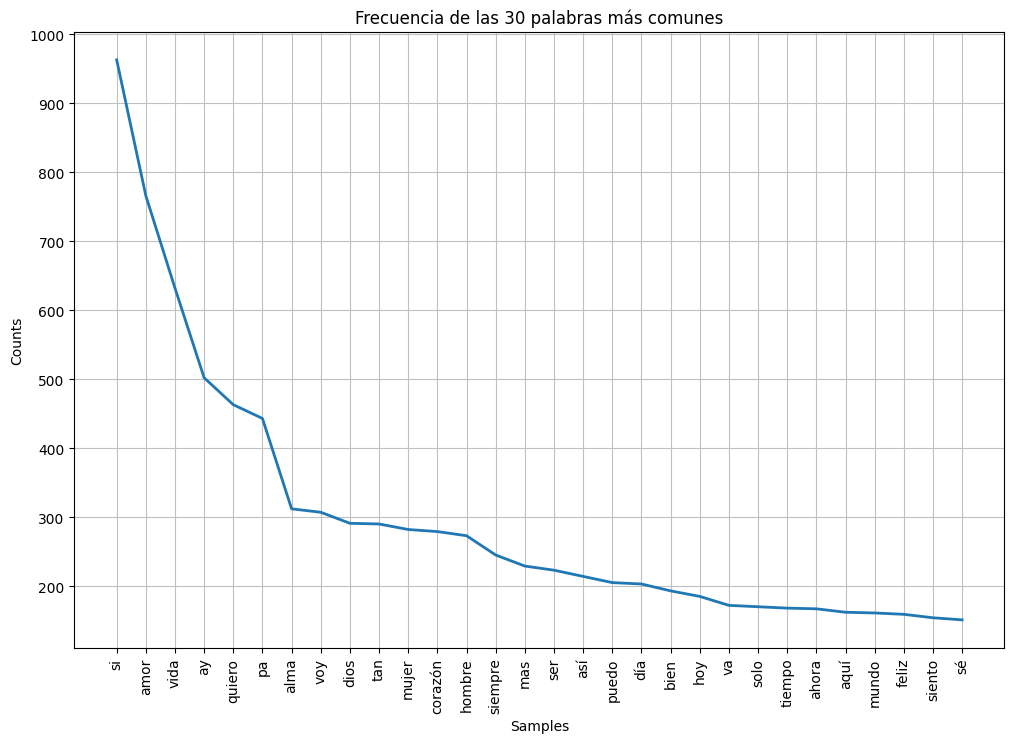

In [ ]:
# ANÁLISIS DE FRECUENCIA

if 'df' in locals():

    # Obtener la lista de stop words en español
    stop_words = set(nltk.corpus.stopwords.words('spanish'))

    # Unir todas las letras en un solo bloque de texto
    texto_completo = ' '.join(df['letra_completa'].dropna())

    # Tokenizar (dividir en palabras)
    palabras = nltk.word_tokenize(texto_completo)

    # Filtrar palabras que no son stop words y que son alfabéticas
    palabras_filtradas = [palabra for palabra in palabras if palabra.isalpha() and palabra not in stop_words]

    # Calcular la frecuencia de cada palabra
    fdist = nltk.FreqDist(palabras_filtradas)

    print(f"\nVocabulario total (palabras únicas sin stop words): {len(fdist)}")
    print("\nLas 30 palabras más comunes")
    for palabra, frecuencia in fdist.most_common(30):
        print(f"{palabra}: {frecuencia}")

    # --- Visualización ---
    plt.figure(figsize=(12, 8))
    fdist.plot(30, title='Frecuencia de las 30 palabras más comunes', cumulative=False)
    plt.show()

## NUBE DE PALABRAS

Esta es una forma visual y atractiva de presentar los resultados del análisis de frecuencia. Se genera una nube de palabras donde las palabras más frecuentes aparecen con un tamaño mayor. Esto nos permite captar de un solo vistazo los conceptos y sentimientos más recurrentes en el repertorio del artista.


Nube de Palabras


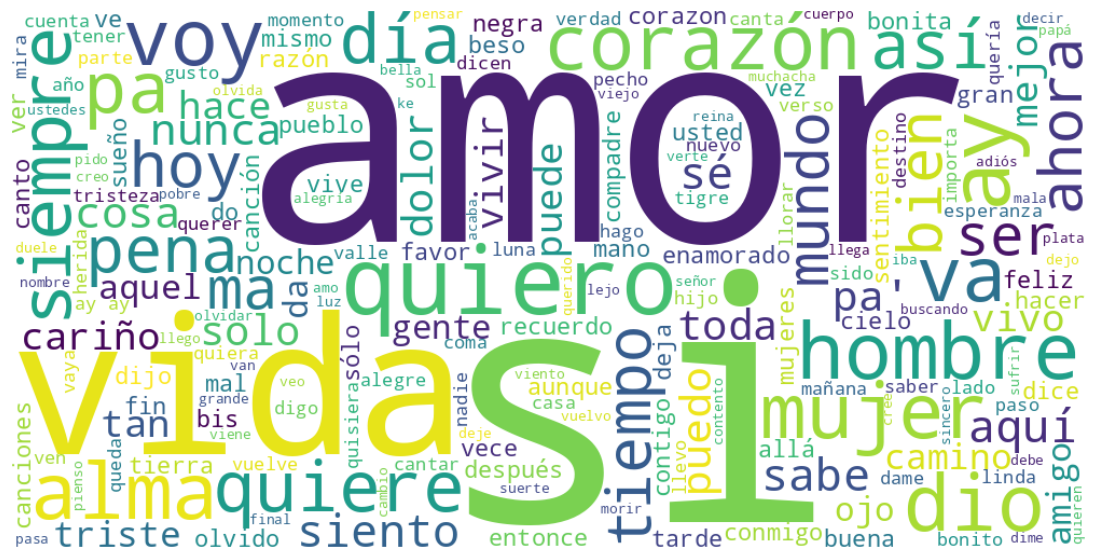

In [ ]:
# NUBE DE PALABRAS

if 'df' in locals() and 'texto_completo' in locals():
    print("\nNube de Palabras")

    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='white',
        stopwords=stop_words, # Usar la misma lista de stop words
        colormap='viridis',
        min_font_size=10
    ).generate(texto_completo)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## ANÁLISIS DE BIGRAMAS

 Aquí analizamos bigramas, que son pares de palabras consecutivas. Identificar los bigramas más comunes (como "mi amor" o "algún día") nos ayuda a descubrir las frases hechas, expresiones y patrones líricos más característicos del compositor.

In [ ]:
# ANÁLISIS DE BIGRAMAS
if 'df' in locals() and 'palabras_filtradas' in locals():
    bigramas = list(nltk.bigrams(palabras_filtradas))
    fdist_bigramas = nltk.FreqDist(bigramas)

    print("\nLos 30 bigramas (frases de 2 palabras) más comunes")
    for (palabra1, palabra2), frecuencia in fdist_bigramas.most_common(30):
        print(f"'{palabra1} {palabra2}': {frecuencia}")


Los 30 bigramas (frases de 2 palabras) más comunes
'ay ay': 55
'coma tigre': 48
'si vas': 42
'ay amor': 40
'ser feliz': 32
'ver si': 32
'tigre coma': 32
'pueda ser': 31
'amor tan': 30
'puedo vivir': 25
'tan bonita': 23
'tan solo': 21
'misma vaina': 21
'si quieres': 21
'muchas veces': 21
'si vuelve': 21
'voy hacer': 20
'tan grande': 19
'mas mas': 19
'cada rato': 19
'vida si': 19
'vuelve loco': 19
'loco chambaculera': 19
'vida vida': 18
'algún día': 18
'hace tiempo': 18
'dios mio': 17
'amor alma': 16
'tal vez': 16
'virgen carmen': 16


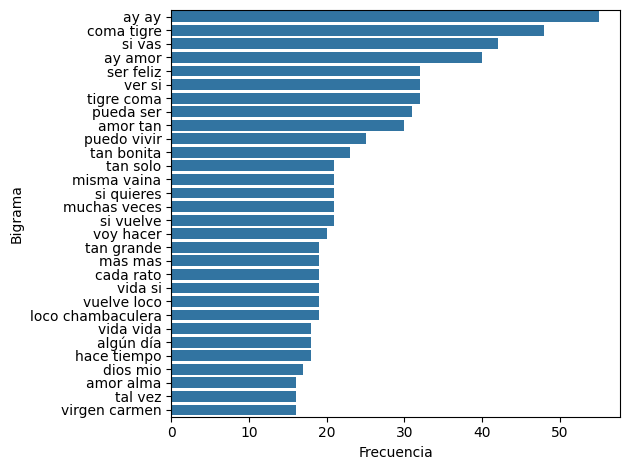

In [ ]:
bigramas_comunes = fdist_bigramas.most_common(30)
df_bigramas = pd.DataFrame(bigramas_comunes, columns=['bigramas', 'frecuencia'])
df_bigramas['bigramas'] = df_bigramas['bigramas'].apply(lambda x: ' '.join(x))
df_bigramas = df_bigramas.sort_values('frecuencia', ascending=False)

# Gráfico
plt.figure()
sns.barplot(y='bigramas', x='frecuencia', data=df_bigramas)
plt.xlabel('Frecuencia')
plt.ylabel('Bigrama')
plt.tight_layout()
plt.show()